Plotting functions. Copied direcly from the code online. Added the line to make it work on notebook


In [58]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
# Plot image examples.
def plot_img(img, title):
    plt.figure()
    plt.imshow(img, interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()

def img_stretch(img):
    img = img.astype(float)
    img -= np.min(img)
    img /= np.max(img)+1e-12
    return img

def img_tile(imgs, aspect_ratio=1.0, tile_shape=None, border=1,
             border_color=0, stretch=False):
    ''' Tile images in a grid.
    If tile_shape is provided only as many images as specified in tile_shape
    will be included in the output.
    '''
    # Prepare images
    if stretch:
        imgs = img_stretch(imgs)
    imgs = np.array(imgs)
    if imgs.ndim != 3 and imgs.ndim != 4:
        raise ValueError('imgs has wrong number of dimensions.')
    n_imgs = imgs.shape[0]
    # Grid shape
    img_shape = np.array(imgs.shape[1:3])
    if tile_shape is None:
        img_aspect_ratio = img_shape[1] / float(img_shape[0])
        aspect_ratio *= img_aspect_ratio
        tile_height = int(np.ceil(np.sqrt(n_imgs * aspect_ratio)))
        tile_width = int(np.ceil(np.sqrt(n_imgs / aspect_ratio)))
        grid_shape = np.array((tile_height, tile_width))
    else:
        assert len(tile_shape) == 2
        grid_shape = np.array(tile_shape)
    # Tile image shape
    tile_img_shape = np.array(imgs.shape[1:])
    tile_img_shape[:2] = (img_shape[:2] + border) * grid_shape[:2] - border
    # Assemble tile image
    tile_img = np.empty(tile_img_shape)
    tile_img[:] = border_color
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            img_idx = j + i*grid_shape[1]
            if img_idx >= n_imgs:
                # No more images - stop filling out the grid.
                break
            img = imgs[img_idx]
            yoff = (img_shape[0] + border) * i
            xoff = (img_shape[1] + border) * j
            tile_img[yoff:yoff+img_shape[0], xoff:xoff+img_shape[1], ...] = img
    return tile_img

def conv_filter_tile(filters):
    n_filters, n_channels, height, width = filters.shape
    tile_shape = None
    if n_channels == 3:
        # Interpret 3 color channels as RGB
        filters = np.transpose(filters, (0, 2, 3, 1))
    else:
        # Organize tile such that each row corresponds to a filter and the
        # columns are the filter channels
        tile_shape = (n_channels, n_filters)
        filters = np.transpose(filters, (1, 0, 2, 3))
        filters = np.resize(filters, (n_filters*n_channels, height, width))
    filters = img_stretch(filters)
    return img_tile(filters, tile_shape=tile_shape)
    
def scale_to_unit_interval(ndar, eps=1e-8):
  """ Scales all values in the ndarray ndar to be between 0 and 1 """
  ndar = ndar.copy()
  ndar -= ndar.min()
  ndar *= 1.0 / (ndar.max() + eps)
  return ndar


def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
  """
  Transform an array with one flattened image per row, into an array in
  which images are reshaped and layed out like tiles on a floor.

  This function is useful for visualizing datasets whose rows are images,
  and also columns of matrices for transforming those rows
  (such as the first layer of a neural net).

  :type X: a 2-D ndarray or a tuple of 4 channels, elements of which can
  be 2-D ndarrays or None;
  :param X: a 2-D array in which every row is a flattened image.

  :type img_shape: tuple; (height, width)
  :param img_shape: the original shape of each image

  :type tile_shape: tuple; (rows, cols)
  :param tile_shape: the number of images to tile (rows, cols)

  :param output_pixel_vals: if output should be pixel values (i.e. int8
  values) or floats

  :param scale_rows_to_unit_interval: if the values need to be scaled before
  being plotted to [0,1] or not


  :returns: array suitable for viewing as an image.
  (See:`PIL.Image.fromarray`.)
  :rtype: a 2-d array with same dtype as X.

  """

  assert len(img_shape) == 2
  assert len(tile_shape) == 2
  assert len(tile_spacing) == 2

  # The expression below can be re-written in a more C style as
  # follows :
  #
  # out_shape = [0,0]
  # out_shape[0] = (img_shape[0] + tile_spacing[0]) * tile_shape[0] -
  #                tile_spacing[0]
  # out_shape[1] = (img_shape[1] + tile_spacing[1]) * tile_shape[1] -
  #                tile_spacing[1]
  out_shape = [(ishp + tsp) * tshp - tsp for ishp, tshp, tsp
                      in zip(img_shape, tile_shape, tile_spacing)]

  if isinstance(X, tuple):
      assert len(X) == 4
      # Create an output numpy ndarray to store the image
      if output_pixel_vals:
          out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype='uint8')
      else:
          out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype=X.dtype)

      #colors default to 0, alpha defaults to 1 (opaque)
      if output_pixel_vals:
          channel_defaults = [0, 0, 0, 255]
      else:
          channel_defaults = [0., 0., 0., 1.]

      for i in range(4):
          if X[i] is None:
              # if channel is None, fill it with zeros of the correct
              # dtype
              out_array[:, :, i] = np.zeros(out_shape,
                      dtype='uint8' if output_pixel_vals else out_array.dtype
                      ) + channel_defaults[i]
          else:
              # use a recurrent call to compute the channel and store it
              # in the output
              out_array[:, :, i] = tile_raster_images(X[i], img_shape, tile_shape, tile_spacing, scale_rows_to_unit_interval, output_pixel_vals)
      return out_array

  else:
      # if we are dealing with only one channel
      H, W = img_shape
      Hs, Ws = tile_spacing

      # generate a matrix to store the output
      out_array = np.zeros(out_shape, dtype='uint8' if output_pixel_vals else X.dtype)


      for tile_row in range(tile_shape[0]):
          for tile_col in range(tile_shape[1]):
              if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                  if scale_rows_to_unit_interval:
                      # if we should scale values to be between 0 and 1
                      # do this by calling the `scale_to_unit_interval`
                      # function
                      this_img = scale_to_unit_interval(X[tile_row * tile_shape[1] + tile_col].reshape(img_shape))
                  else:
                      this_img = X[tile_row * tile_shape[1] + tile_col].reshape(img_shape)
                  # add the slice to the corresponding position in the
                  # output array
                  out_array[
                      tile_row * (H+Hs): tile_row * (H + Hs) + H,
                      tile_col * (W+Ws): tile_col * (W + Ws) + W
                      ] \
                      = this_img * (255 if output_pixel_vals else 1)
      return out_array


In [59]:
import argparse
import time
import numpy as np
import sys
import pickle
import torch
from google.colab import files
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
use_cuda = torch.cuda.is_available()

The upload function allows me to get local data onto colab.

In [45]:
uploaded = files.upload()

Unpickle has been taken directly from original code. Is not needed for smaller test cases, as I preprocessed them locally. This snippet will load all of the data.

In [ ]:
def unpickle(file):
    fo = open(file, 'rb')
    d = pickle.load(fo, encoding='latin1')
    fo.close()
    return {'x': np.cast[np.float32]((-127.5 + d['data'].reshape((10000,3,32,32)))/128.), 'y': np.array(d['labels']).astype(np.uint8)}

train_data = [unpickle('cifar-10-batches-py/data_batch_' + str(i)) for i in range(1,6)]
trainx = np.concatenate([d['x'] for d in train_data],axis=0)
trainy = np.concatenate([d['y'] for d in train_data],axis=0)
test_data = unpickle(os.path.join(data_dir,'cifar-10-batches-py/test_batch'))
testx = test_data['x']
testy = test_data['y']

This smaller dataset was used for testing. It does not need unpickling.

In [60]:
f1 = open("data_sample_small","rb")
f2 = open("test_batch_small","rb")
tr,test = pickle.load(f1),pickle.load(f2)
trainx,trainy = tr['x'],tr['y']
testx,testy = test['x'],test['y']
f1.close()
f2.close()

Set some parameters that are used later.

In [61]:
seed = 1
seed_data = 1
batch_size = 10
lr = 0.0003
count=50
noise_dim = (batch_size, 100)
if use_cuda:
    torch.cuda.manual_seed_all(seed)

Setting seeds and creating random objects

In [62]:
# fixed random seeds
rng_data = np.random.RandomState(seed_data)
noise_rng = np.random.RandomState(seed_data+seed)

Creating the custom Dataset to load the data and the corresponding dataloaders

In [63]:
class DiscTrainDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data_sample,data_labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.d = data_sample
        self.lab = data_labels
        self.d_unl1 = data_sample[rng_data.permutation(data_sample.shape[0])]
        self.d_unl2 = data_sample[rng_data.permutation(data_sample.shape[0])]
        self.transform = transform

    def __len__(self):
        return len(self.d)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x_lab = torch.tensor(self.d[idx])
        lab = torch.tensor(self.lab[idx])
        x_unl1 = torch.tensor(self.d_unl1[idx])
        x_unl2 = torch.tensor(self.d_unl2[idx])
        sample = {'x_lab': x_lab, 'lab': lab, 'x_unl1':x_unl1, 'x_unl2':x_unl2}
        #transformations
        return sample
dataset_loader_train = DataLoader(dataset=DiscTrainDataset(trainx,trainy),batch_size=batch_size, num_workers=8, shuffle=True)
dataset_loader_test = DataLoader(dataset=DiscTrainDataset(testx,testy),batch_size=batch_size, num_workers=8)

The generator and discriminator models. They have been designed based on the theano implementation.

In [64]:
# Generator Code
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main1 = nn.Sequential(
            nn.Linear(100, 4*4*512, bias=True),
            nn.BatchNorm1d(4*4*512),
            nn.ReLU()
        )
        self.main2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 5, stride =2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 5, stride =2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.utils.weight_norm(nn.ConvTranspose2d(128, 3, 5, stride =2, padding=2, output_padding=1)),
            nn.Tanh()
        )
    def forward(self, input):
        x = self.main1(input)
        x = x.view(x.size(0),512,4,4)
        x = self.main2(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main1 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.utils.weight_norm(nn.Conv2d(3, 96, 3, stride = 1, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.Conv2d(96, 96, 3, stride = 1, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.Conv2d(96, 96, 3, stride = 2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.5),
            nn.utils.weight_norm(nn.Conv2d(96, 192, 3, stride=1, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.Conv2d(192, 192, 3, stride=1, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.Conv2d(192, 192, 3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.5),
            nn.utils.weight_norm(nn.Conv2d(192, 192, 3, stride=1, padding=0)),
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.Conv2d(192, 192, 1, stride=1, padding=0)),
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.Conv2d(192, 192, 1, stride=1, padding=0)),
            nn.LeakyReLU(0.2),
           nn.MaxPool2d(6)
        )
        self.last_layer = nn.utils.weight_norm(nn.Linear(192, 10, bias=True))

    def forward(self, input, matching = False):
        x = self.main1(input)
        # x = nn.functional.adaptive_avg_pool2d(x,[1,1])
        if matching:
            return x
        x = x.view(x.size(0),-1)
        x = self.last_layer(x)
        return torch.squeeze(x)

In [65]:
gen = Generator()
disc = Discriminator()
if use_cuda:
    gen = torch.nn.DataParallel(gen).cuda()
    disc = torch.nn.DataParallel(disc).cuda()

In [66]:
def log_sum_exp(x):
    m = torch.max(x,dim=1)[0]
    s = torch.logsumexp(x-m, 1)
    return s+m

Weight initializations are from the original implementation.

In [67]:
def weights_init(m):
    classname=m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose2d')!= -1:
        nn.init.normal_(m.weight.data, 0.0, 0.05)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.05)
        nn.init.constant_(m.bias.data, 0)

disc.apply(weights_init)
gen.apply(weights_init)

DataParallel(
  (module): Generator(
    (main1): Sequential(
      (0): Linear(in_features=100, out_features=8192, bias=True)
      (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (main2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
      (7): Tanh()
    )
  )
)

The optimiser used is Adam.

In [68]:
# initialize optimisers
Doptim = torch.optim.Adam(disc.parameters(),lr=lr, betas = (0.9,0.999))
Goptim = torch.optim.Adam(gen.parameters(),lr=lr, betas = (0.9,0.999))

Functions to run the model on a batch, and train the model, computing the losses

In [69]:
def train_discriminator(x_lab,labels,x_unl):
    #torch.autograd.set_detect_anomaly(True)
    noise = torch.tensor(noise_rng.uniform(size=noise_dim)).float()
    if use_cuda:
        noise = noise.cuda()
        x_lab = x_lab.cuda()
        x_unl = x_unl.cuda()
        labels = labels.cuda()
    disc.train()
    gen.train()
    output_before_softmax_lab = disc(x_lab)
    output_before_softmax_unl = disc(x_unl)
    output_before_softmax_gen = disc(gen(noise))
    l_lab_ind = [(i,j.item()) for i,j in zip(np.arange(batch_size),labels)]
    l_lab = torch.tensor([output_before_softmax_lab[x] for x in l_lab_ind])
    l_unl = log_sum_exp(output_before_softmax_unl)
    l_gen = log_sum_exp(output_before_softmax_gen)
    ll = -torch.mean(l_lab) + torch.mean(log_sum_exp(output_before_softmax_lab))
    lu = -0.5*torch.mean(l_unl) + 0.5*torch.mean(nn.functional.softplus(l_unl)) + 0.5*torch.mean(nn.functional.softplus(l_gen))
    total_loss = ll+lu
    te = torch.mean(torch.ne(torch.argmax(output_before_softmax_lab,dim=1),labels).float())
    Doptim.zero_grad()
    total_loss.backward()
    Doptim.step()
    return ll,lu,te

def train_generator(x_unl):
    noise = torch.tensor(noise_rng.uniform(size=noise_dim)).float()
    if use_cuda:
        noise = noise.cuda()
        x_unl = x_unl.cuda()
    disc.train()
    gen.train()
    output_unl = disc(x_unl, matching=True)
    output_gen = disc(gen(noise), matching = True)
    m1 = torch.mean(output_unl,dim=0)
    m2 = torch.mean(output_gen,dim=0)
    loss_gen = torch.mean(torch.abs(m1-m2)) # feature matching loss
    Goptim.zero_grad()
    loss_gen.backward()
    Goptim.step()
    return loss_gen.item()

def update_historical_average(disc_avg_params):
    disc_params = [param.data for param in disc.parameters()]
    if disc_avg_params == None:
        return disc_params
    return [a+0.0001*(p-a) for p,a in zip(disc_params,disc_avg_params)]

def test_model(x_lab,labels):
    disc.eval()
    with torch.no_grad():
        if use_cuda:
            x_lab = x_lab.cuda()
            labels = labels.cuda()
        output_before_softmax = disc(x_lab)
        test_batch_err = torch.mean(torch.ne(torch.argmax(output_before_softmax,dim=1),labels).float())
    return test_batch_err.item()


Training is made parallel to the original implementation. Theano functions were opened up and replaced by the functions defined above.


Iteration 0, time = 12s, loss_lab = 330.9755, loss_unl = 229.6410, train err = 0.0866, test err = 0.0890
Iteration 1, time = 12s, loss_lab = 1.2515, loss_unl = 0.1208, train err = 0.0878, test err = 0.0890
Iteration 2, time = 12s, loss_lab = 0.2304, loss_unl = 0.1226, train err = 0.0900, test err = 0.0890
Iteration 3, time = 12s, loss_lab = 0.2303, loss_unl = 0.1225, train err = 0.0900, test err = 0.0890
Iteration 4, time = 12s, loss_lab = 0.2303, loss_unl = 0.1224, train err = 0.0900, test err = 0.0890
Iteration 5, time = 12s, loss_lab = 0.2303, loss_unl = 0.1224, train err = 0.0900, test err = 0.0890
Iteration 6, time = 12s, loss_lab = 0.2303, loss_unl = 0.1223, train err = 0.0900, test err = 0.0890
Iteration 7, time = 12s, loss_lab = 0.2303, loss_unl = 0.1222, train err = 0.0900, test err = 0.0890


KeyboardInterrupt: ignored

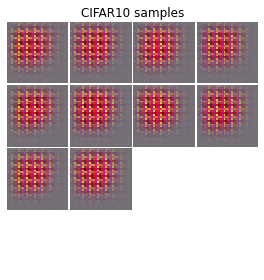

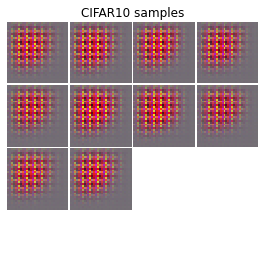

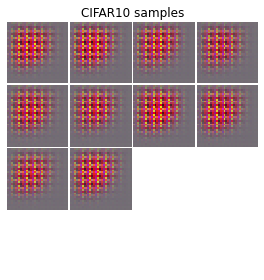

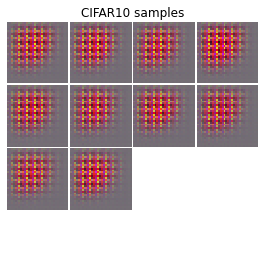

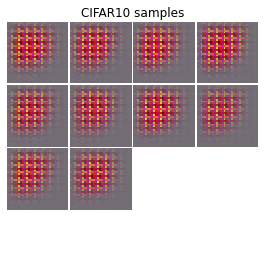

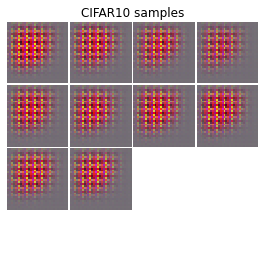

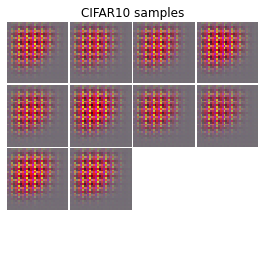

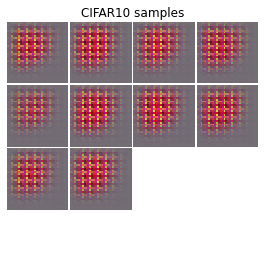

In [70]:
for epoch in range(1200):
    begin = time.time()
    lr = lr*min(3-epoch/400,1)
    for param_group in Doptim.param_groups:
        param_group['lr'] = lr
    for param_group in Goptim.param_groups:
        param_group['lr'] = lr
    # This entire process needs to be replaced by a dataloader.
    
    # train
    loss_lab = 0.
    loss_unl = 0.
    train_err = 0.
    loss_gen = 0.
    disc_avg_params = None
    for _,d in enumerate(dataset_loader_train):
        x_lab = d["x_lab"]
        labels = d["lab"]
        x_unl = d["x_unl1"]
        ll,lu,te = train_discriminator(x_lab,labels,x_unl)
        loss_lab += ll
        loss_unl += lu
        train_err += te

        disc_avg_params = update_historical_average(disc_avg_params)
        x_unl = d["x_unl2"]
        lg = train_generator(x_unl)
        loss_gen += lg

    loss_lab /= (_+1)*batch_size
    loss_unl /= (_+1)*batch_size
    loss_gen /= (_+1)*batch_size
    train_err /= (_+1)*batch_size
    # test
    test_err = 0.
 
    original_params = [param.data for param in disc.parameters()]
    for param,avg_param in zip(disc.parameters(),disc_avg_params):
        param.data.copy_(avg_param)

    for _,d in enumerate(dataset_loader_test):
        x_lab = d['x_lab']
        labels = d['lab']
        test_batch_error = test_model(x_lab,labels)
        test_err += test_batch_error
    
    for param,o_param in zip(disc.parameters(),original_params):
        param.data.copy_(o_param)
    
    test_err /= (_+1)*batch_size
    # report
    print("Iteration %d, time = %ds, loss_lab = %.4f, loss_unl = %.4f, train err = %.4f, test err = %.4f" % (epoch, time.time()-begin, loss_lab, loss_unl, train_err, test_err))
    sys.stdout.flush()
    # generate sample
    gen.eval()
    with torch.no_grad():
        noise = torch.tensor(noise_rng.uniform(size=noise_dim)).float()
        if use_cuda:
            noise = noise.cuda()
        sample_x = gen(noise)
        sample_x = sample_x.cpu().numpy()
        img_bhwc = np.transpose(sample_x[:100,], (0, 2, 3, 1))
        img_tile_o = img_tile(img_bhwc, aspect_ratio=1.0, border_color=1.0, stretch=True)
        img = plot_img(img_tile_o, title='CIFAR10 samples')


In [ ]:
    # Code to save params
    #np.savez('disc_params.npz', *[p.data for p in disc.parameters()])
    #np.savez('gen_params.npz', *[p.data for p in gen_parameters()])